In [1]:
import re
import cv2
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from helper import *

In [2]:
path = './data/sample_coco.txt'

lines = []
with open(path) as f:
    lines = f.readlines()

In [3]:
columns = ['id', 'height', 'width', 'x', 'y', 'bbox_width', 'bbox_height']

In [4]:
data = pd.DataFrame(datarestructure(columns,dataList=lines))
data = data.astype(dtype=np.int64)
data['n_height'] = [x/x for x in data.height]
data['n_width'] = [x/x for x in data.width]
data['n_x'] = [x/y for x,y in zip(data.x,data.width)]
data['n_y'] = [x/y for x,y in zip(data.y,data.height)]
data['n_bbox_width'] = [x/y for x,y in zip(data.bbox_width,data.width)]
data['n_bbox_height'] = [x/y for x,y in zip(data.bbox_height,data.height)]
data['class'] = data['id'].map(get_class)

In [5]:
data.head()

,id,height,width,x,y,bbox_width,bbox_height,n_height,n_width,n_x,n_y,n_bbox_width,n_bbox_height,class
0,0,330,1093,69,464,312,175,1.0,1.0,0.063129,1.406061,0.285453,0.530303,person
1,1,782,439,359,292,83,199,1.0,1.0,0.817768,0.373402,0.189066,0.254476,bicycle
2,3,645,831,297,312,267,167,1.0,1.0,0.357401,0.483721,0.321300,0.258915,motorcycle
3,34,943,608,275,112,319,290,1.0,1.0,0.452303,0.118770,0.524671,0.307529,baseball bat
4,20,593,857,71,368,146,147,1.0,1.0,0.082847,0.620573,0.170362,0.247892,elephant


In [6]:
data[['n_bbox_width','n_bbox_height']].describe()

,n_bbox_width,n_bbox_height
count,10105.000000,10105.000000
mean,0.323393,0.325578
std,0.147178,0.145902
min,0.046964,0.047344
25%,0.211538,0.217931
50%,0.316785,0.320138
75%,0.414195,0.415625
max,0.894366,0.877551


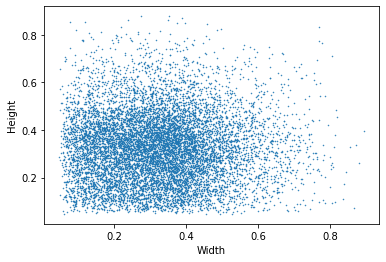

In [7]:
plt.scatter(data['n_bbox_width'], data['n_bbox_height'], s=1, marker='.')
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [8]:
check = data.sample(1000,axis=0)
X = check[['n_bbox_width','n_bbox_height']].reset_index()
X = X.drop(columns=['index'])
final_X= check[['n_bbox_width','n_bbox_height']].reset_index().drop(columns=['index'])

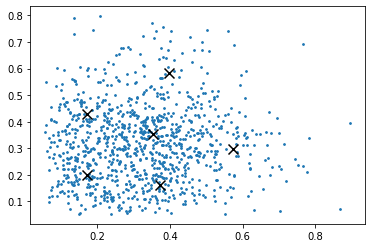

In [9]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X['n_bbox_width'], X['n_bbox_height'],s=3)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black',marker='x')
plt.show()

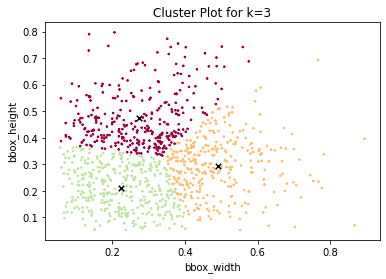

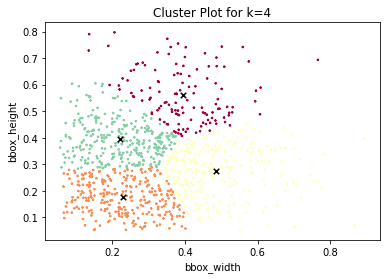

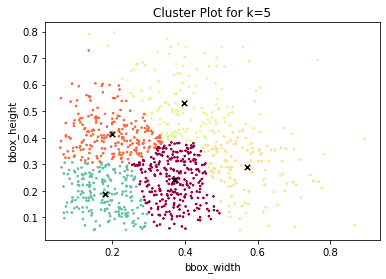

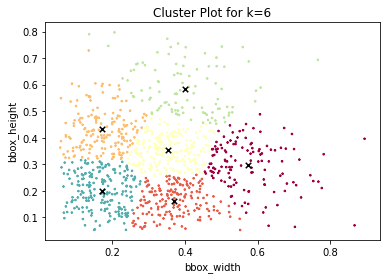

In [10]:
## final_X is for getting cluster values
## X is used for appending anchor box, bb_h_m and bb_w_m
centroid_ls = []
sse= []
clusters=[]
for anchor in np.arange(3,7):
    clusters.append(anchor)
    kmeans = KMeans(n_clusters=anchor, init='k-means++', max_iter=300, n_init=10, random_state=40)
    pred_y = kmeans.fit_predict(final_X)
    centroid = kmeans.cluster_centers_
    sse.append(kmeans.inertia_)    
    cnt =0
    centroid_dict = {}
    centroid_df = pd.DataFrame()
    for i in centroid:
        cnt +=1
        name = '{}'.format(cnt)
        centroid_df[name] = list(1/(abs(X['n_bbox_width'] - i[0])*abs(X['n_bbox_height'] - i[1])))
        centroid_dict[name] = i
    
    centroid_ls.append(centroid_dict)
    ## Anchor Box Number
    X['AnchorBox#'] = centroid_df.idxmax(axis=1)
    
    cmap = plt.cm.get_cmap('Spectral')
    plt.scatter(X['n_bbox_width'], X['n_bbox_height'],s=3,alpha=1,
                c=[cmap(float(i)/len(kmeans.cluster_centers_)) for i in kmeans.labels_],
                cmap='Spectral',marker='x')
    
    plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], 
                color='black',s=30,marker='x')
    
    plt.title('Cluster Plot for k={}'.format(anchor))
    plt.xlabel('bbox_width')
    plt.ylabel('bbox_height')
    plt.show()
    
    width_mul =[]
    height_mul=[]
    for _,i in enumerate(X['AnchorBox#']):
        width_mul.append(centroid_dict[i][0]*X['n_bbox_width'][_])
        height_mul.append(centroid_dict[i][1]*X['n_bbox_height'][_])
    X['width_mul'] = width_mul
    X['height_mul'] = height_mul
    X.to_csv('./data/bbanchor_dataset_centroid{}.csv'.format(anchor),index=False)

In [11]:
centroid_arr = []
for i in range(len(centroid_ls)):
    ls= []
    for key,values in centroid_ls[i].items():
        ls.append(np.array(values))
    centroid_arr.append(np.array(ls))

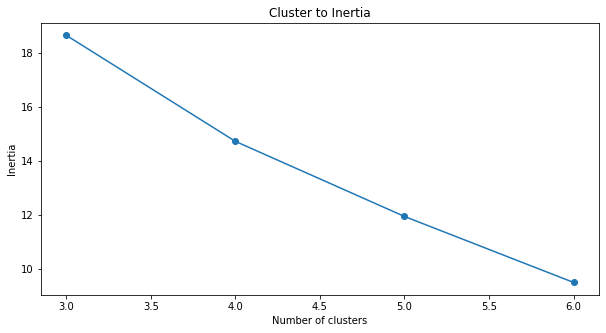

In [12]:
plt.figure(figsize=(10,5))
plt.plot(clusters, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title("Cluster to Inertia")
plt.show()

In [13]:
clusters 

[3, 4, 5, 6]

In [14]:
centroid

array([[0.57374289, 0.29591627],
       [0.37047013, 0.16276945],
       [0.1726737 , 0.43134929],
       [0.35339729, 0.35220254],
       [0.39911004, 0.58360876],
       [0.17086368, 0.20140379]])

In [15]:
ious = []
for c in range(len(clusters)):
    check['iou'+str(c)] = ious.append(avg_iou(np.array(check[[
        'n_bbox_width','n_bbox_height']].apply(lambda x: iou((x['n_bbox_width'], 
                                                              x['n_bbox_height']), centroid_arr[c]), axis=1))))

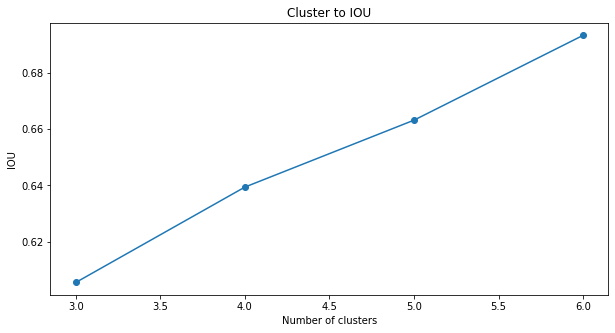

In [16]:
plt.figure(figsize=(10,5))
plt.plot(clusters, ious, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('IOU')
plt.title("Cluster to IOU")
plt.show()

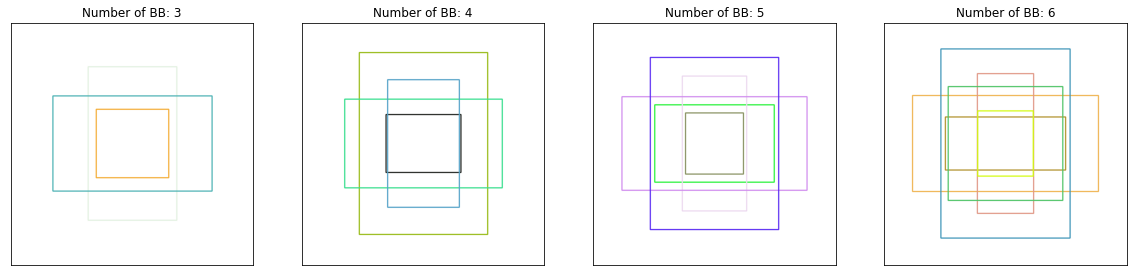

In [20]:
cox, coy = 300, 300
fig = plt.figure(figsize=(20, 5))
for k, exp in enumerate(centroid_arr):
    image = cv2.resize(cv2.imread('./images/white.png'), (600, 600), interpolation=cv2.INTER_AREA)
    for box in exp:
        # scale centroid by 1000 times
        cen = box*800/2
        # box start and end
        start_point = (int(cox-cen[0]), int(coy-cen[1]))
        end_point = (int(cox+cen[0]), int(coy+cen[1]))
        # Colour of BB
        color = (random.randint(0, 255+1), random.randint(0, 255+1), random.randint(0, 255+1))
        # Line thickness of 2 px
        thickness = 2

        # Using cv2.rectangle() method
        # Draw a rectangle with blue line borders of thickness of 2 px
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
    
    ax = fig.add_subplot(1, len(centroid_arr), k + 1, xticks=[], yticks=[])
    ax.set_title("Number of BB: "+ str(len(exp)))
    plt.imshow(image)
plt.show()

In [ ]:
class_spread = dict(data['class'].value_counts())
class_spread = dict(sorted(class_spread.items(), key=lambda item: item[0]))
data = class_spread
names = list(data.keys())
values = list(data.values())

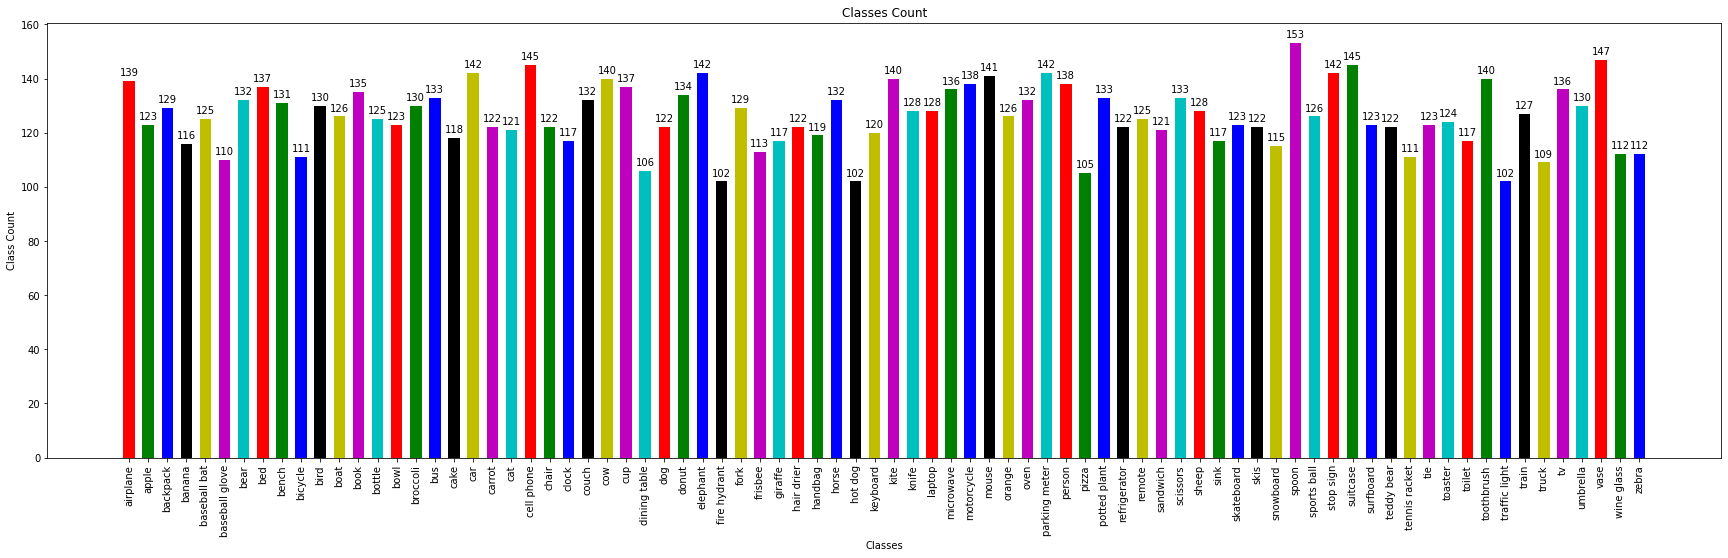

In [35]:
plt.figure(figsize=(30,8)) 
plt.bar(range(len(data)), values, tick_label=names, width=0.6,color = list('rgbkymc'))
for l in range(len(values)):
    plt.annotate(values[l], (-0.50 + l, values[l] + 2))
plt.xticks(rotation='90')
plt.xlabel("Classes")
plt.ylabel("Class Count")
plt.title("Classes Count")
plt.show()